In [1]:
from tensorflow import keras
import tensorflow as tf
from keras import models
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import img_to_array
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import rcParams
import cv2 as cv2
import copy
import sklearn.metrics
from sklearn.linear_model import Ridge
import math
from PIL import Image

import skimage.segmentation as ss
from skimage.segmentation import mark_boundaries as sb
from skimage.metrics import structural_similarity as ssim

In [2]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
num_classes = dataset_info.features['label'].num_classes
print(f"num_classes: {num_classes}")

num_classes: 5


In [4]:
class_names = dataset_info.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 3303
Total Number of Validation Images: 367 



In [6]:
IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 150
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [7]:
image_batch, label_batch = next(iter(validation_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [8]:
model = models.load_model('ResNet50')

In [9]:
test_sample, _ = next(iter(validation_batches))

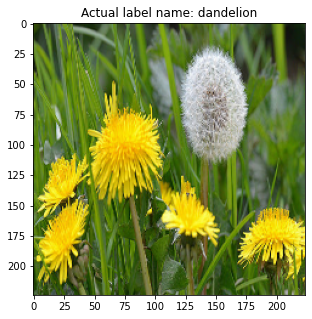

In [10]:
plt.rcParams['font.size']=10
plt.figure(figsize=(5,5))
plt.imshow(test_sample[105].numpy())
plt.title(f"Actual label name: {class_names[label_batch[105]]}");

In [11]:
test_image = test_sample[105].numpy()

In [12]:
def n_top_classes(image):
    predicted_label_res = model.predict(image[np.newaxis,...])
    predicted_label_res = tf.squeeze(predicted_label_res).numpy()
    class_sorted = np.argsort(predicted_label_res)[::-1]
    for i, pred in enumerate(class_sorted):
        print("Top {} predicted class: {}   class name: {}   predicted_prob: {:.5f}"
              .format(i+1, class_sorted[i], class_names[pred], predicted_label_res[pred]))
    return class_sorted[0], class_names[class_sorted[0]], predicted_label_res[class_sorted[0]]

In [13]:
print("Sample image:")
class_explain, class_name, predicted_prob = n_top_classes(test_image)

Sample image:
Top 1 predicted class: 0   class name: dandelion   predicted_prob: 0.83732
Top 2 predicted class: 1   class name: daisy   predicted_prob: 0.16071
Top 3 predicted class: 3   class name: sunflowers   predicted_prob: 0.00193
Top 4 predicted class: 2   class name: tulips   predicted_prob: 0.00003
Top 5 predicted class: 4   class name: roses   predicted_prob: 0.00000


In [14]:
def s_slic(image, compactness, n_segments):
    superpixels = ss.slic(image.astype('double'), compactness=compactness, n_segments=n_segments)
    num_superpixels = np.unique(superpixels).shape[0]
    return superpixels, num_superpixels

#Create function to apply perturbations to images
def perturb_image(image, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(image)
    perturbed_image = perturbed_image * mask[:,:,np.newaxis]
    return perturbed_image

def heatmap(active_features, coeff_features, superpixels):
    #active_pixels = np.where(active_features == 1)[0]
    active_pixels = np.where(coeff_features !=1)[0]
    mask_coeff = np.zeros(superpixels.shape)
    for active in active_pixels:
        mask_coeff[superpixels == active] = coeff_features[active]
    heatmap =  mask_coeff[:,:]
    return heatmap

def xai_lime(image, superpixels, num_superpixels, class_explain):
# Parameters
    num_perturbations = 10 * num_superpixels
    #num_top_features = num_superpixels
    num_top_features = math.ceil(0.4*num_superpixels)
    predictions = []
    kernel_width = 0.25
    simpler_model = Ridge(alpha=0)   
    perturbations = np.random.binomial(1, 0.5, size=(num_perturbations, num_superpixels))

    for p in perturbations:
        perturbed_image = perturb_image(image, p, superpixels)
        prediction = model.predict(perturbed_image[np.newaxis,...])
        predictions.append(prediction)
    predictions=np.array(predictions)

#Compute distances to original image
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

#Transform distances to a value between 0 and 1 (weights) using a kernel function
     
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

#Estimate linear model
    class_to_explain = class_explain
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
    top_features = np.argsort(coeff)[-num_top_features:] 
    features = np.zeros(num_superpixels) 
    features[top_features]= True #Activate top superpixels
    resutls_xai = perturb_image(image, features, superpixels)
    return weights, perturbations, predictions, resutls_xai, num_top_features, features, coeff

In [15]:
def n_top_classes(image):
    predicted_label_res = model.predict(image[np.newaxis,...])
    predicted_label_res = tf.squeeze(predicted_label_res).numpy()
    class_sorted = np.argsort(predicted_label_res)[::-1]
    for i, pred in enumerate(class_sorted):
        print("Top {} predicted class: {}   class name: {}   predicted_prob: {:.5f}"
              .format(i+1, class_sorted[i], class_names[pred], predicted_label_res[pred]))
    return class_sorted[0], class_names[class_sorted[0]], predicted_label_res[class_sorted[0]]

In [16]:
seg1, n_seg1 = s_slic(test_image, 20,16)
seg2, n_seg2 = s_slic(test_image, 20,25)
seg3, n_seg3 = s_slic(test_image, 20,36)
seg4, n_seg4 = s_slic(test_image, 20,49)
seg5, n_seg5 = s_slic(test_image, 20,64)
seg6, n_seg6 = s_slic(test_image, 20,81)
seg7, n_seg7 = s_slic(test_image, 20,100)
seg8, n_seg8 = s_slic(test_image, 20,121)
seg9, n_seg9 = s_slic(test_image, 20,144)
seg10, n_seg10 = s_slic(test_image, 20,196)
seg11, n_seg11 = s_slic(test_image, 20,225)
seg12, n_seg12 = s_slic(test_image, 20,256)
seg13, n_seg13 = s_slic(test_image, 20,289)
seg14, n_seg14 = s_slic(test_image, 20,324)
seg15, n_seg15 = s_slic(test_image, 20,361)
seg16, n_seg16 = s_slic(test_image, 20,400)

C:\Users\hoori\AppData\Local\Temp/ipykernel_7328/4148549768.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  superpixels = ss.slic(image.astype('double'), compactness=compactness, n_segments=n_segments)


In [17]:
segments = [16,25,36,49,64,81,100,121,144,196,225,256,289,324,361,400]
sqr_segments = np.sqrt(segments)

In [18]:
num_segments = [n_seg1,n_seg2,n_seg3,n_seg4,n_seg5,n_seg6,n_seg7,n_seg8,
               n_seg9,n_seg10,n_seg11,n_seg12,n_seg13,n_seg14,n_seg15,n_seg16]

In [19]:
weights1, samples1, predicted_probs1, seg1_slic, top_f_seg1, features_seg1, coeff_seg1 = xai_lime(test_image, seg1, n_seg1, class_explain)
weights2, samples2, predicted_probs2, seg2_slic, top_f_seg2, features_seg2, coeff_seg2 = xai_lime(test_image, seg2, n_seg2, class_explain)
weights3, samples3, predicted_probs3, seg3_slic, top_f_seg3, features_seg3, coeff_seg3 = xai_lime(test_image, seg3, n_seg3, class_explain)
weights4, samples4, predicted_probs4, seg4_slic, top_f_seg4, features_seg4, coeff_seg4 = xai_lime(test_image, seg4, n_seg4, class_explain)
weights5, samples5, predicted_probs5, seg5_slic, top_f_seg5, features_seg5, coeff_seg5 = xai_lime(test_image, seg5, n_seg5, class_explain)
weights6, samples6, predicted_probs6, seg6_slic, top_f_seg6, features_seg6, coeff_seg6 = xai_lime(test_image, seg6, n_seg6, class_explain)
weights7, samples7, predicted_probs7, seg7_slic, top_f_seg7, features_seg7, coeff_seg7 = xai_lime(test_image, seg7, n_seg7, class_explain)
weights8, samples8, predicted_probs8, seg8_slic, top_f_seg8, features_seg8, coeff_seg8 = xai_lime(test_image, seg8, n_seg8, class_explain)
weights9, samples9, predicted_probs9, seg9_slic, top_f_seg9, features_seg9, coeff_seg9 = xai_lime(test_image, seg9, n_seg9, class_explain)
weights10, samples10, predicted_probs10, seg10_slic, top_f_seg10, features_seg10, coeff_seg10 = xai_lime(test_image, seg10, n_seg10, class_explain)
weights11, samples11, predicted_probs11, seg11_slic, top_f_seg11, features_seg11, coeff_seg11 = xai_lime(test_image, seg11, n_seg11, class_explain)
weights12, samples12, predicted_probs12, seg12_slic, top_f_seg12, features_seg12, coeff_seg12 = xai_lime(test_image, seg12, n_seg12, class_explain)
weights13, samples13, predicted_probs13, seg13_slic, top_f_seg13, features_seg13, coeff_seg13 = xai_lime(test_image, seg13, n_seg13, class_explain)
weights14, samples14, predicted_probs14, seg14_slic, top_f_seg14, features_seg14, coeff_seg14 = xai_lime(test_image, seg14, n_seg14, class_explain)
weights15, samples15, predicted_probs15, seg15_slic, top_f_seg15, features_seg15, coeff_seg15 = xai_lime(test_image, seg15, n_seg15, class_explain)
weights16, samples16, predicted_probs16, seg16_slic, top_f_seg16, features_seg16, coeff_seg16 = xai_lime(test_image, seg16, n_seg16, class_explain)

In [20]:
heatmap_seg1 = heatmap(features_seg1, coeff_seg1, seg1)
heatmap_seg2 = heatmap(features_seg2, coeff_seg2, seg2)
heatmap_seg3 = heatmap(features_seg3, coeff_seg3, seg3)
heatmap_seg4 = heatmap(features_seg4, coeff_seg4, seg4)
heatmap_seg5 = heatmap(features_seg5, coeff_seg5, seg5)
heatmap_seg6 = heatmap(features_seg6, coeff_seg6, seg6)
heatmap_seg7 = heatmap(features_seg7, coeff_seg7, seg7)
heatmap_seg8 = heatmap(features_seg8, coeff_seg8, seg8)
heatmap_seg9 = heatmap(features_seg9, coeff_seg9, seg9)
heatmap_seg10 = heatmap(features_seg10, coeff_seg10, seg10)
heatmap_seg11 = heatmap(features_seg11, coeff_seg11, seg11)
heatmap_seg12 = heatmap(features_seg12, coeff_seg12, seg12)
heatmap_seg13 = heatmap(features_seg13, coeff_seg13, seg13)
heatmap_seg14 = heatmap(features_seg14, coeff_seg14, seg14)
heatmap_seg15 = heatmap(features_seg15, coeff_seg15, seg15)
heatmap_seg16 = heatmap(features_seg16, coeff_seg16, seg16)

In [21]:
multi_heatmaps = [heatmap_seg1,heatmap_seg2,heatmap_seg3,heatmap_seg4,
                  heatmap_seg5,heatmap_seg6,heatmap_seg7,heatmap_seg8,
                  heatmap_seg9,heatmap_seg10,heatmap_seg11,heatmap_seg12,
                 heatmap_seg13,heatmap_seg14,heatmap_seg15,heatmap_seg16]

coefficients = [coeff_seg1,coeff_seg2,coeff_seg3,coeff_seg4,coeff_seg5,coeff_seg6,
               coeff_seg7,coeff_seg8,coeff_seg9,coeff_seg10,coeff_seg11,coeff_seg12,
               coeff_seg13,coeff_seg14,coeff_seg15,coeff_seg16]

In [22]:
#### Normalizing heatmaps
for i in range(len(multi_heatmaps)):
    multi_heatmaps[i] = (multi_heatmaps[i]-np.min(multi_heatmaps[i]))/(np.max(multi_heatmaps[i])-np.min(multi_heatmaps[i]))
#### Min and Max values per heatmap after normalization
min_val = []
max_val = []
for i in range(len(multi_heatmaps)):
    min_val.append(np.min(multi_heatmaps[i]))
    max_val.append(np.max(multi_heatmaps[i]))
heatmaps_val = pd.DataFrame(data=[min_val, max_val], 
                            columns=num_segments,
                            index=['Min','Max']).rename_axis('Heatmaps',axis='columns')

In [23]:
def visual_explanation(n,mu,sigma,heatmaps):
    weighted_combination = 0
    r = range(-int(n/2),int(n/2)+1)
    weights = [1 / (sigma * sqrt(2*pi)) * exp(-float(x-mu)**2/(2*sigma**2)) for x in r]
    for i in range(len(weights)):
        weighted_combination += weights[i]*(heatmaps[i])
    return weighted_combination

def gauss(n,m,sigma):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x-m)**2/(2*sigma**2)) for x in r]

In [24]:
#### Explanations - Coarse & Fine scales

coarse_exp = []
for i in range(0,5):
    coarse_exp.append(multi_heatmaps[i])
    
fine_exp = []
for i in range(0,12):
    fine_exp.append(multi_heatmaps[i])
    
finest_exp = []
for i in range(11,len(multi_heatmaps)):
    finest_exp.append(multi_heatmaps[i])

explanation_coarse = visual_explanation(5,0,5,coarse_exp)
explanation_fine = visual_explanation(11,0,5,fine_exp)
explanation_finest = visual_explanation(5,0,5,finest_exp)

explanation_coarse = (explanation_coarse-np.min(explanation_coarse))/(np.max(explanation_coarse)-np.min(explanation_coarse))
explanation_fine = (explanation_fine-np.min(explanation_fine))/(np.max(explanation_fine)-np.min(explanation_fine))
explanation_finest = (explanation_finest-np.min(explanation_finest))/(np.max(explanation_finest)-np.min(explanation_finest))

exp_lime_coarse = cv2.addWeighted(explanation_coarse.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)
    
exp_lime_fine = cv2.addWeighted(explanation_fine.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

exp_lime_finest = cv2.addWeighted(explanation_finest.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

Localization of traditional LIME vs multi-scale scheme

In [25]:
superpixels_lime = ss.slic(test_image)
num_superpixels_lime = np.unique(superpixels_lime).shape[0]

C:\Users\hoori\AppData\Local\Temp/ipykernel_7328/2915358630.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  superpixels_lime = ss.slic(test_image)


In [26]:
weights_lime, samples_lime, predicted_probs_lime, seg_slic_lime, top_f_lime, features_lime, coeff_lime = xai_lime(test_image, superpixels_lime, num_superpixels_lime, class_explain)
heatmap_lime = heatmap(features_lime, coeff_lime, superpixels_lime)

In [27]:
heatmap_lime_norm = (heatmap_lime-np.min(heatmap_lime))/(np.max(heatmap_lime-np.min(heatmap_lime)))
exp_lime = heatmap_lime_norm[...,np.newaxis] * test_image
exp_lime_superimposed = cv2.addWeighted(heatmap_lime_norm.astype('float64'),0.6,
                                                test_image[:,:,0].astype('float64'),0.4,0)

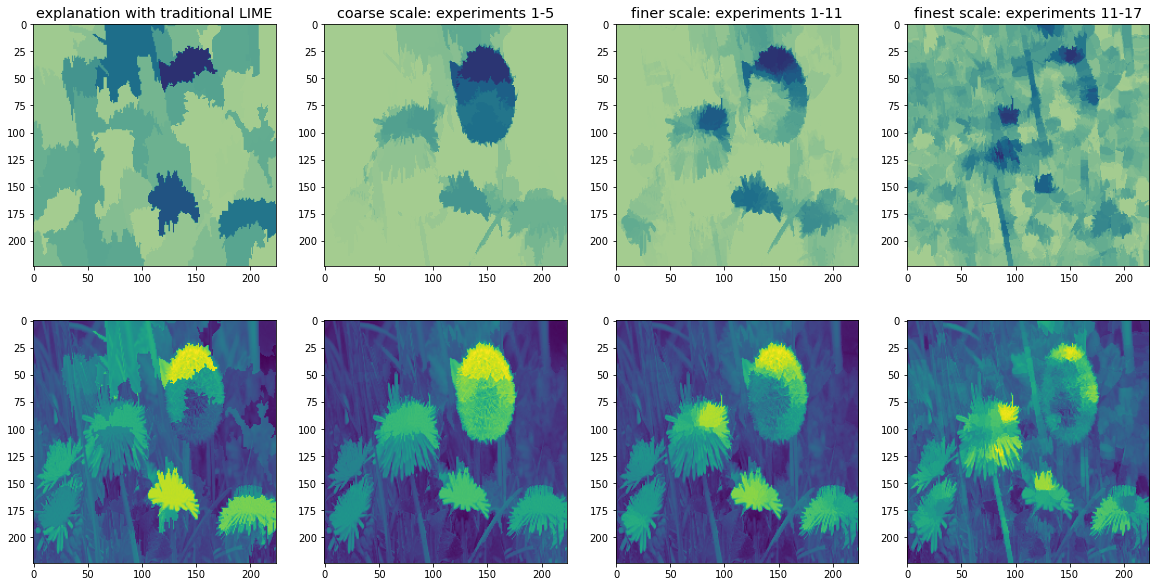

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
plt.rcParams["font.size"] = 12
ax = axes.ravel()
ax[0].imshow(heatmap_lime_norm, cmap='crest', vmin=0.2)
ax[0].set_title('explanation with traditional LIME')
ax[1].imshow(explanation_coarse,cmap='crest', vmin=0.2)
ax[1].set_title("coarse scale: experiments 1-5")
ax[2].imshow(explanation_fine,cmap='crest', vmin=0.2)
ax[2].set_title("finer scale: experiments 1-11")
ax[3].imshow(explanation_finest,cmap='crest', vmin=0.2)
ax[3].set_title("finest scale: experiments 11-17");

ax[4].imshow(exp_lime_superimposed)
# ax[4].set_title('superimposed-traditional LIME')
ax[5].imshow(exp_lime_coarse)
# ax[5].set_title("superimposed scale 1")
ax[6].imshow(exp_lime_fine)
# ax[6].set_title("superimposed scale 2")
ax[7].imshow(exp_lime_finest);
# ax[7].set_title("Superimposed scale 3");

Explanation accuracy

In [29]:
exp_image_1 = test_image * explanation_coarse[..., np.newaxis]
exp_image_2 = test_image * explanation_fine[..., np.newaxis]
exp_image_3 = test_image * explanation_finest[..., np.newaxis]

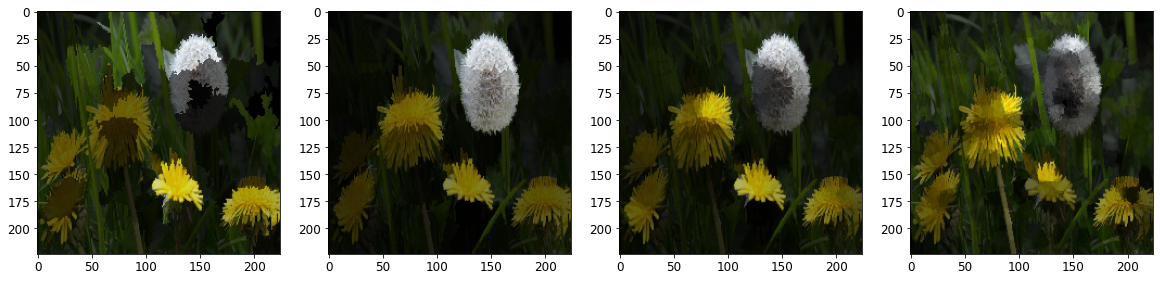

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
plt.rcParams["font.size"] = 12
ax = axes.ravel()
ax[0].imshow(exp_lime)
# ax[0].set_title(f'masked image \n with traditional LIME: {0.999}')
ax[1].imshow(exp_image_1)
# ax[1].set_title(f'masked heat-maps 1:5 \n explanation acc: {0.999}')
ax[2].imshow(exp_image_2)
# ax[2].set_title(f'masked heat-maps 1:11 \n explanation acc: {1}')
ax[3].imshow(exp_image_3);
# ax[3].set_title(f'masked heat-maps 11:16 \n explanation acc: {0.999}');

First predicted class vs Second one

Text(0.5, 1.0, 'finest scale: experiments 11-17')

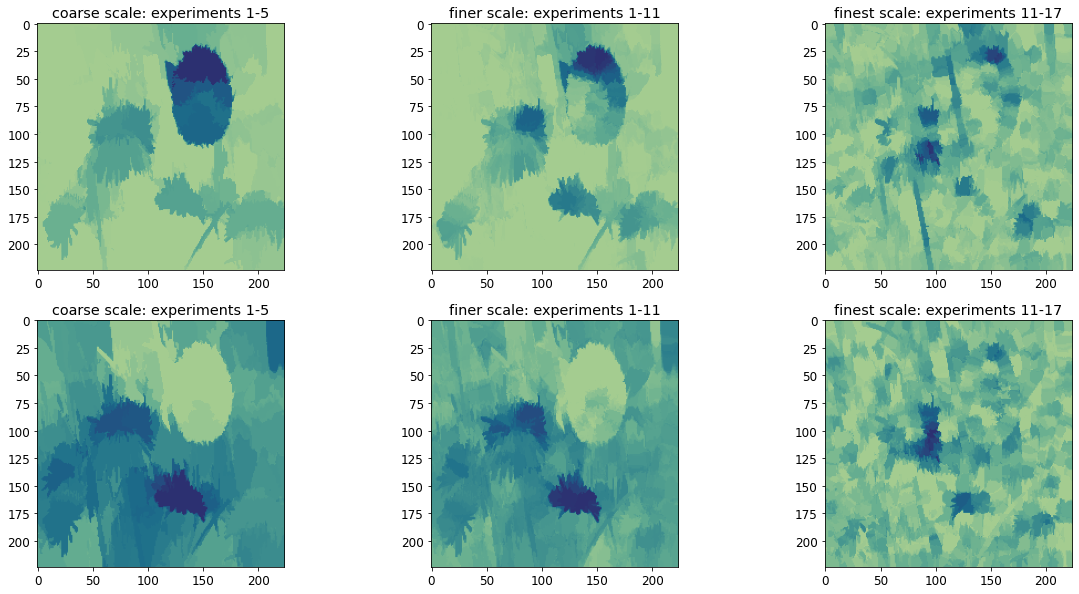

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
plt.rcParams["font.size"] = 12
ax = axes.ravel()
ax[0].imshow(explanation_coarse,cmap='crest', vmin=0.2)
ax[0].set_title("coarse scale: experiments 1-5")
ax[1].imshow(explanation_fine,cmap='crest', vmin=0.2)
ax[1].set_title("finer scale: experiments 1-11")
ax[2].imshow(explanation_finest,cmap='crest', vmin=0.2)
ax[2].set_title("finest scale: experiments 11-17")
# Second predicted calss
ax[3].imshow(explanation_coarse_c2,cmap='crest', vmin=0.2)
ax[3].set_title("coarse scale: experiments 1-5")
ax[4].imshow(explanation_fine_c2,cmap='crest', vmin=0.2)
ax[4].set_title("finer scale: experiments 1-11")
ax[5].imshow(explanation_finest_c2,cmap='crest', vmin=0.2)
ax[5].set_title("finest scale: experiments 11-17")